In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [2]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mplfooty.pitch import Pitch
from viz.afl_colours import team_colours

from exp_vaep.domain.vaep.vaep import *
from exp_vaep.domain.vaep.chain_visualisations import *

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

In [3]:
font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/fonts"
for x in os.listdir(font_path):
    if x != ".DS_Store":
        for y in os.listdir(f"{font_path}/{x}"):
            if y.split(".")[-1] == "ttf":
                fm.fontManager.addfont(f"{font_path}/{x}/{y}")
                try:
                    fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
                except Exception:
                    continue

In [4]:
plt.style.use("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/mplstyle/dark_theme.mplstyle")

Load VAEP Data

In [5]:
chain_data = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/scored_match_chains_v2.csv")
chain_data.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,ReceiverTeam,Receiver,xT_created,xT_denied,match_id,chain_number,order,overall_seconds,start_x,start_y,end_x,end_y,action_type,outcome_type,scores,concedes,offensive_value,defensive_value,vaep_value,xScore,exp_scores,exp_concedes,exp_offensive_value,exp_defensive_value,exp_vaep_value
0,1,centreBounce,goal,1.0,1,13,13.0,Brisbane Lions,NaN,NaN,NaN,Centre Bounce,0.0,0.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,centreBounce,goal,2.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Hard Ball Get,8.0,-5.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Dayne Zorko,0.005595,NaN,202101_BrisbaneLions_Sydney,1.0,2.0,24.0,8.0,-5.0,9.0,-6.0,Hard Ball Get,effective,0.059166,0.004202,0.000000,-0.000000,0.000000,NaN,0.359902,0.069447,0.000000,-0.000000,0.000000
2,1,centreBounce,goal,3.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Handball,9.0,-6.0,ineffective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,NaN,0.0,202101_BrisbaneLions_Sydney,1.0,3.0,24.0,9.0,-6.0,-11.0,7.0,Handball,ineffective,0.013482,0.020271,-0.045684,-0.016070,-0.061754,NaN,0.000000,0.094798,-0.359902,-0.025351,-0.385253
3,1,centreBounce,goal,4.0,1,13,28.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Loose Ball Get,11.0,-7.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,0.000000,NaN,202101_BrisbaneLions_Sydney,1.0,4.0,28.0,-11.0,7.0,-12.0,5.0,Loose Ball Get,effective,0.041042,0.016021,0.020770,-0.002539,0.018231,NaN,0.271695,0.118642,0.176897,-0.118642,0.058255
4,1,centreBounce,goal,5.0,1,13,29.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Handball,12.0,-5.0,effective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,George Hewett,0.007561,NaN,202101_BrisbaneLions_Sydney,1.0,5.0,29.0,-12.0,5.0,-14.0,2.0,Handball,effective,0.028680,0.018624,-0.012362,-0.002603,-0.014965,NaN,0.376785,0.103702,0.105090,0.014940,0.120030


Plotting Chains with VAEP Values

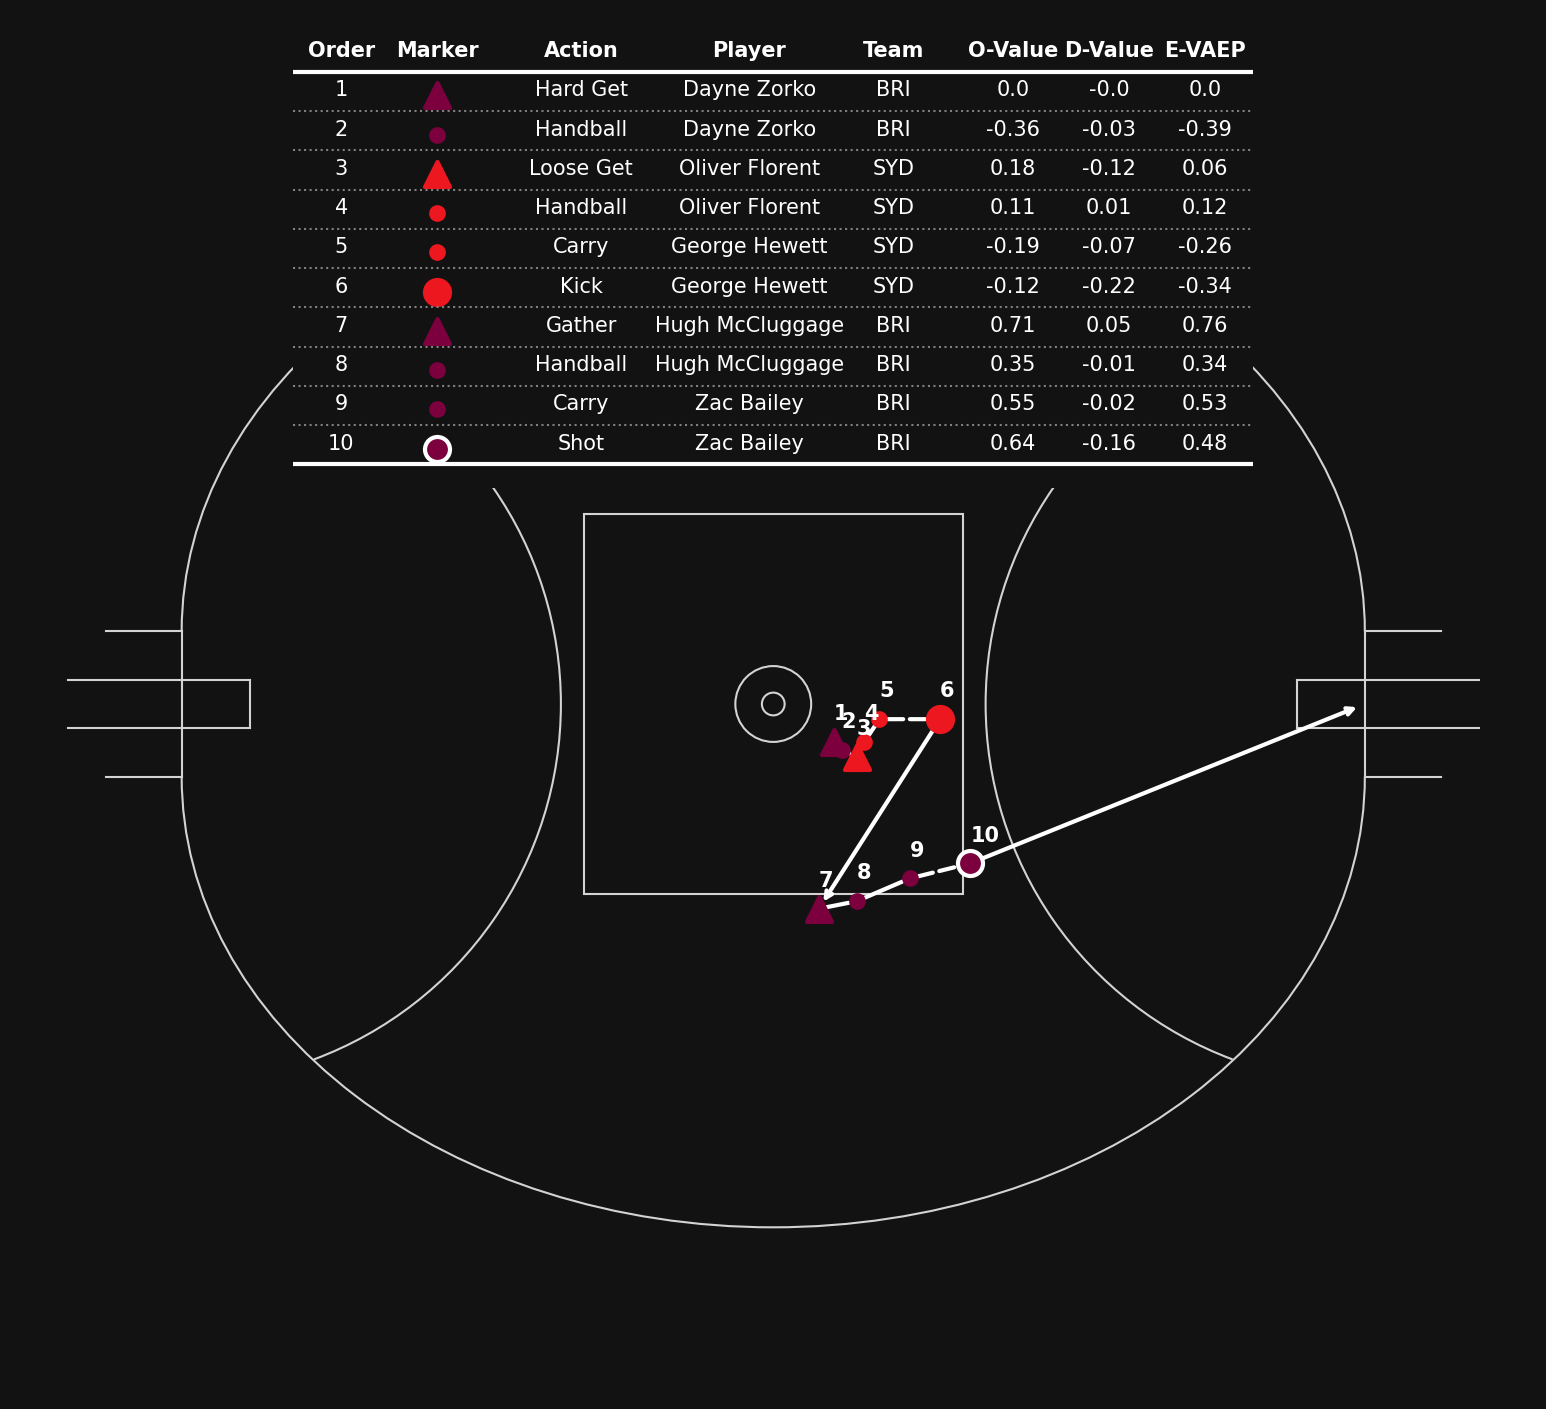

In [7]:
match_id = "202101_BrisbaneLions_Sydney"
chain_number = 1
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

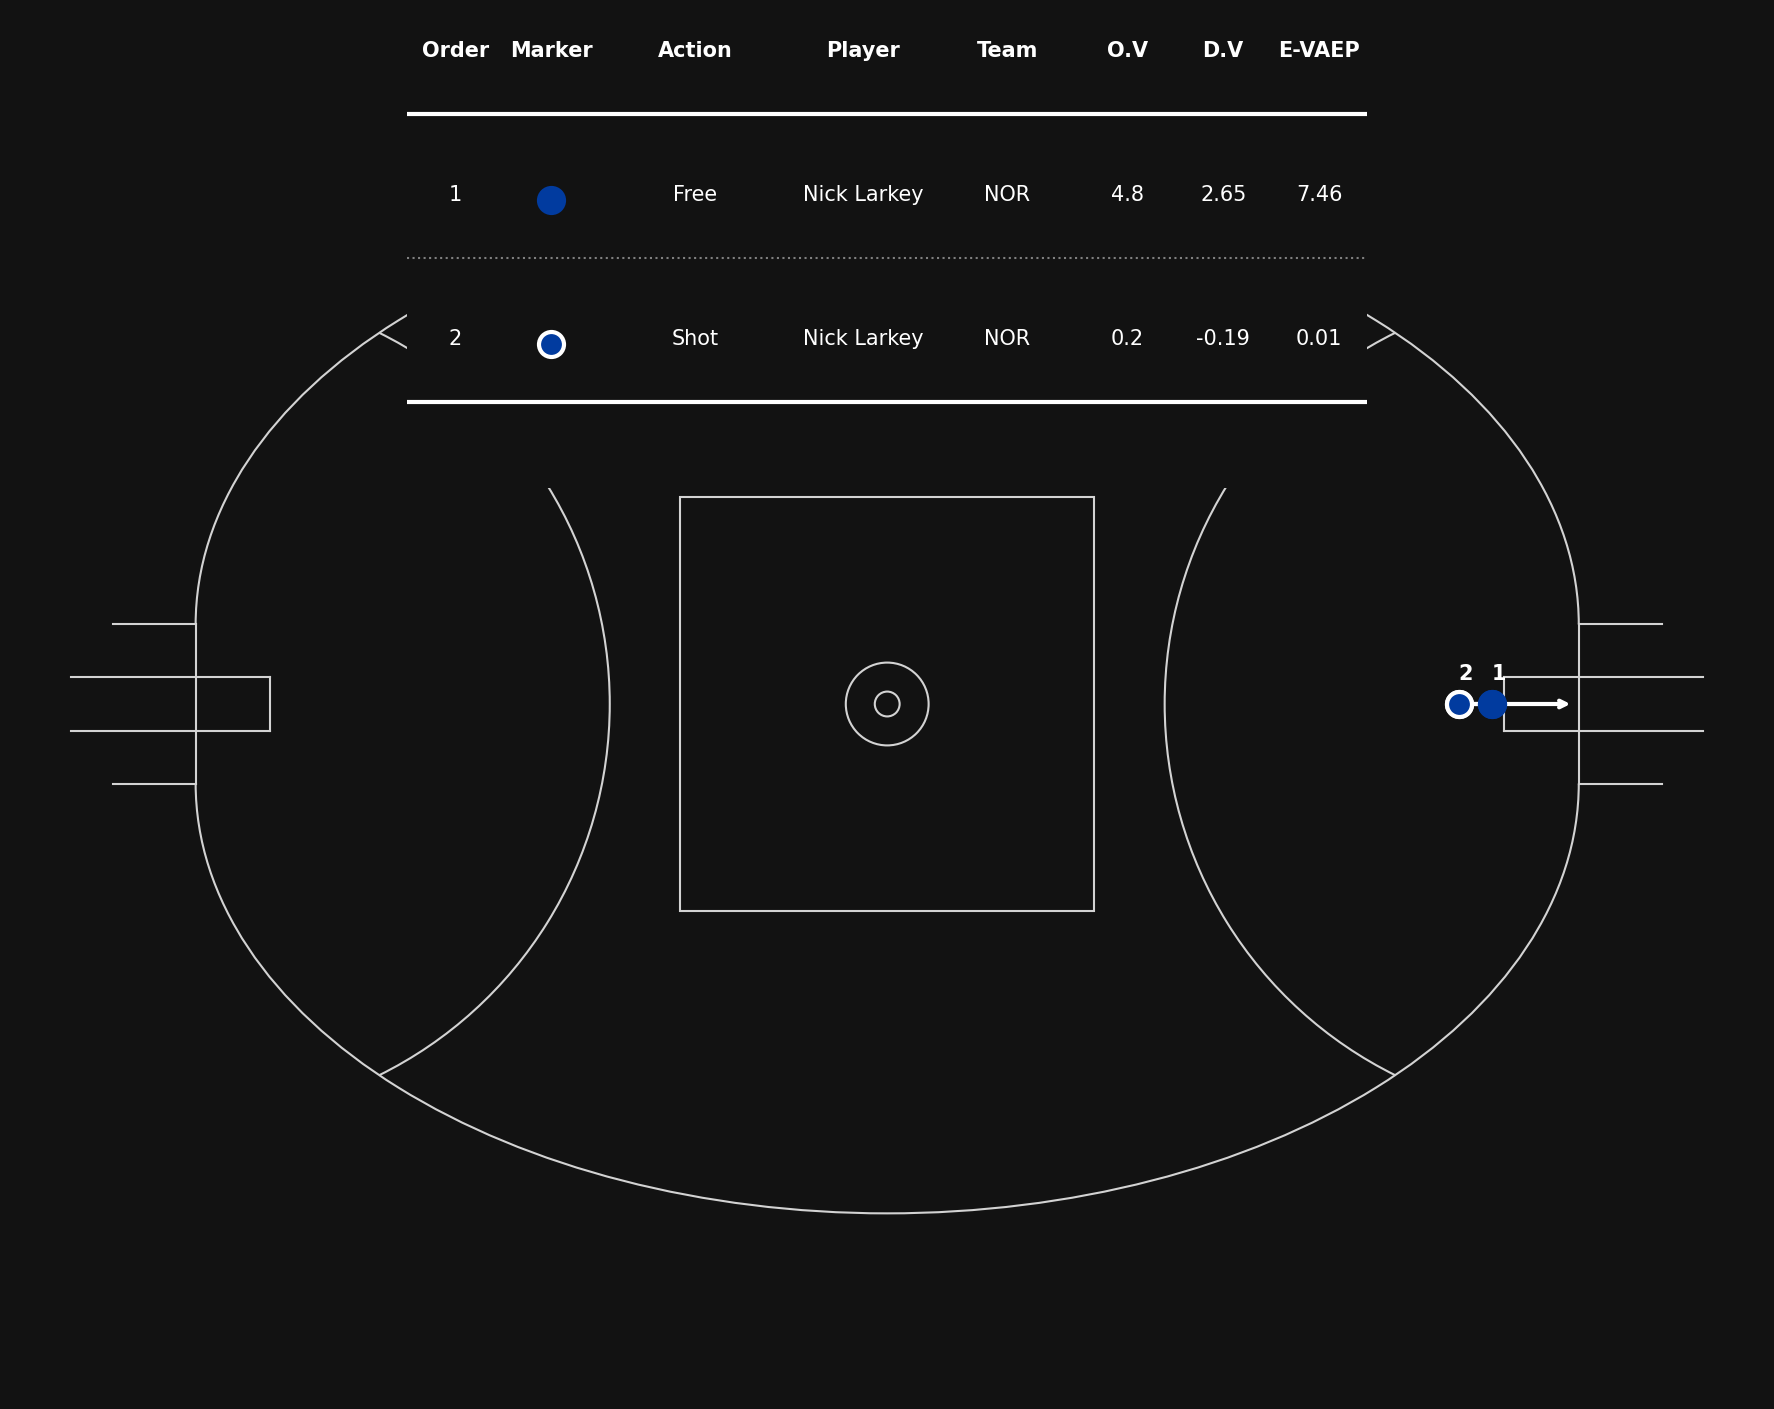

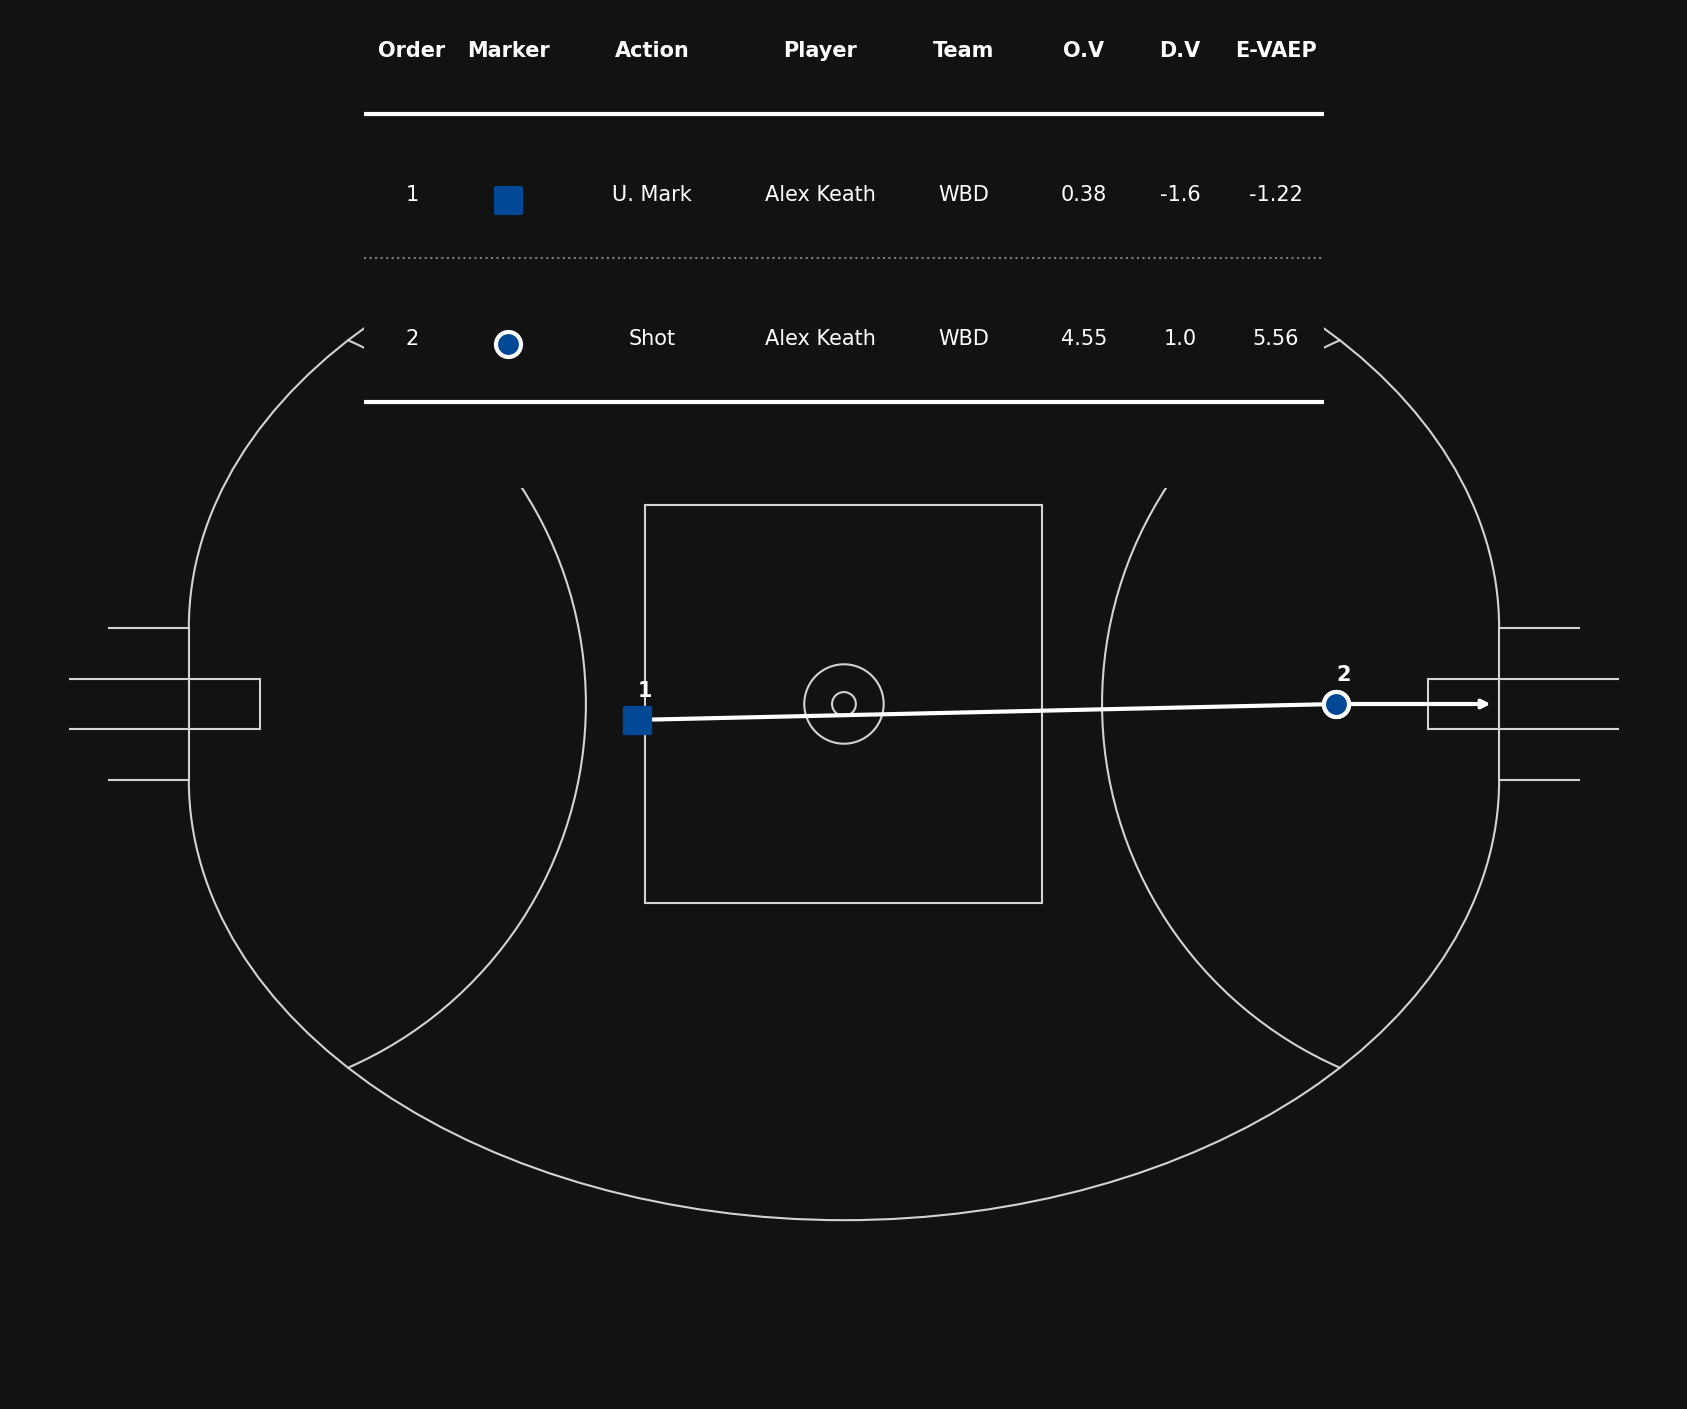

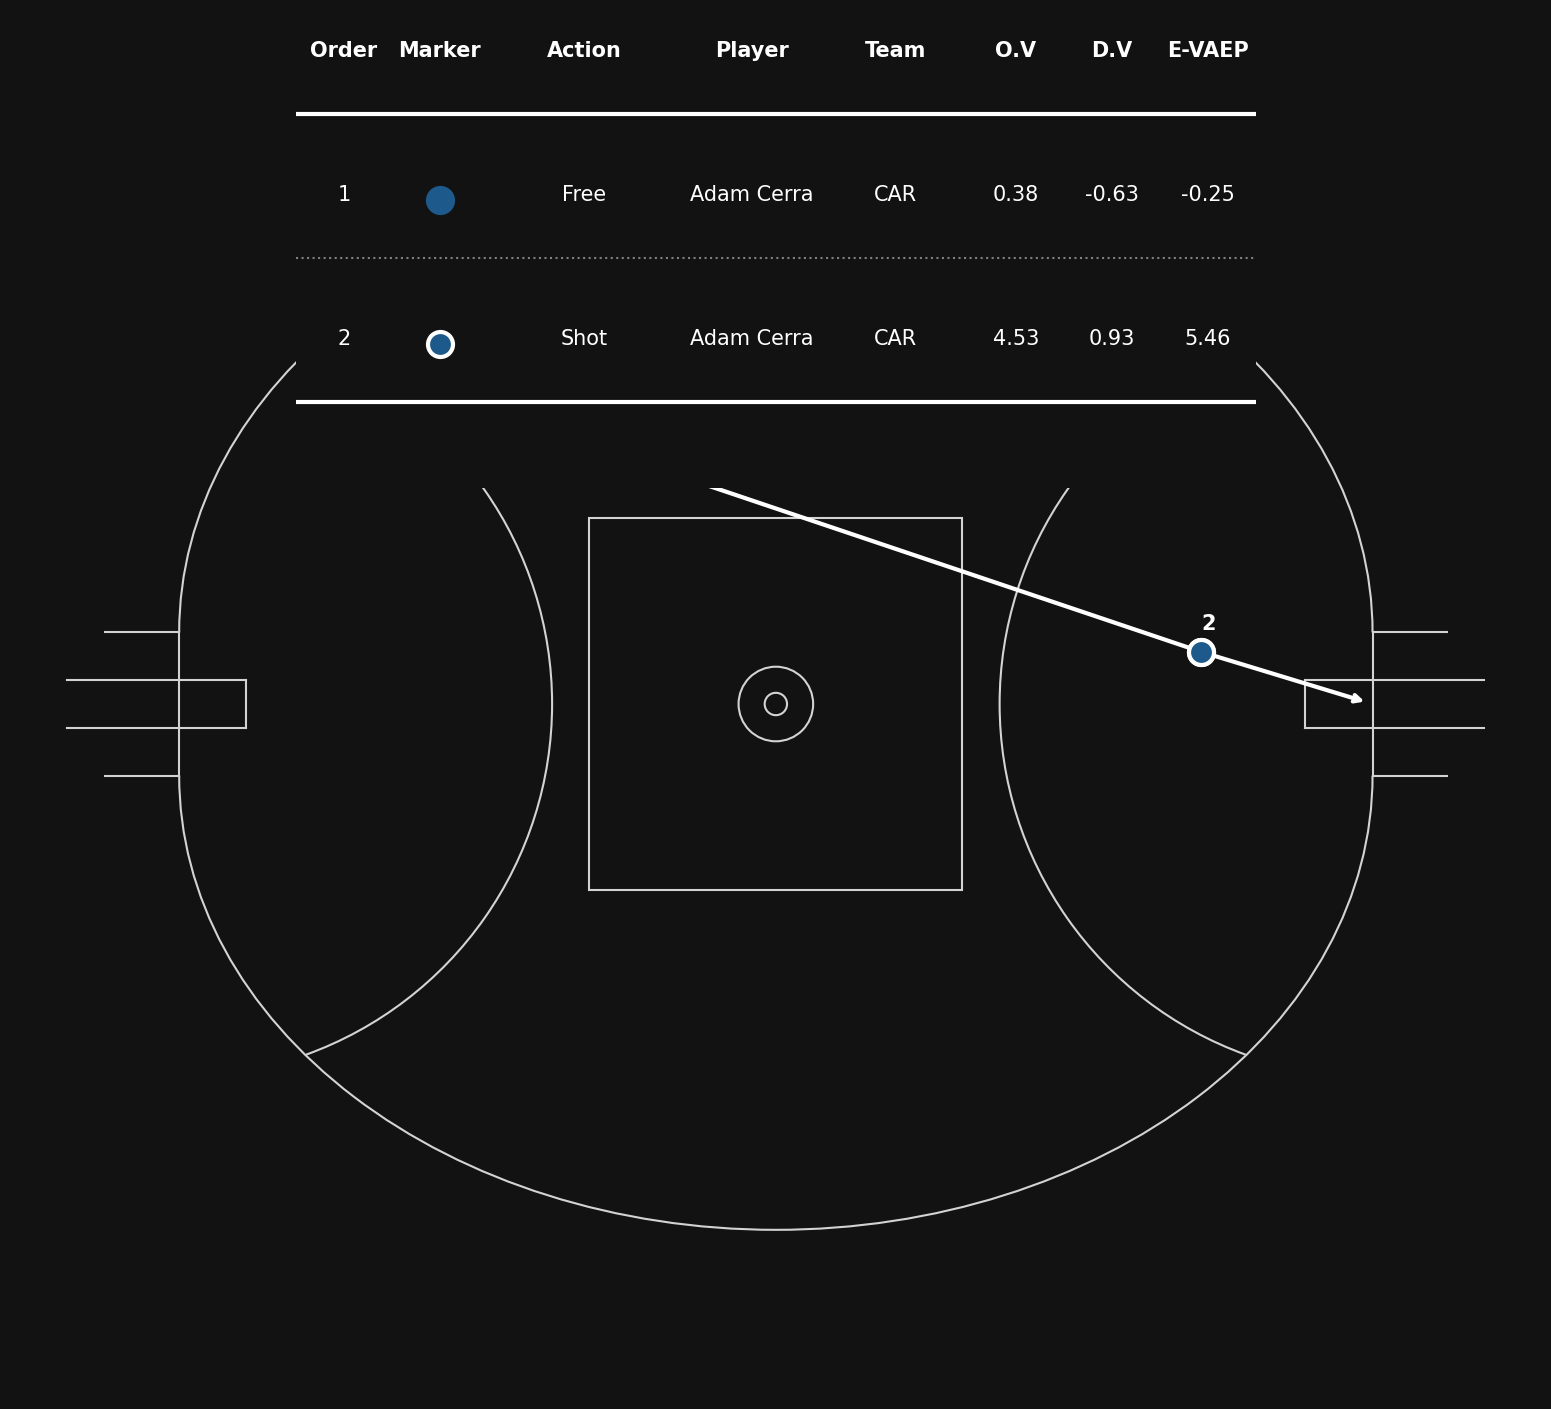

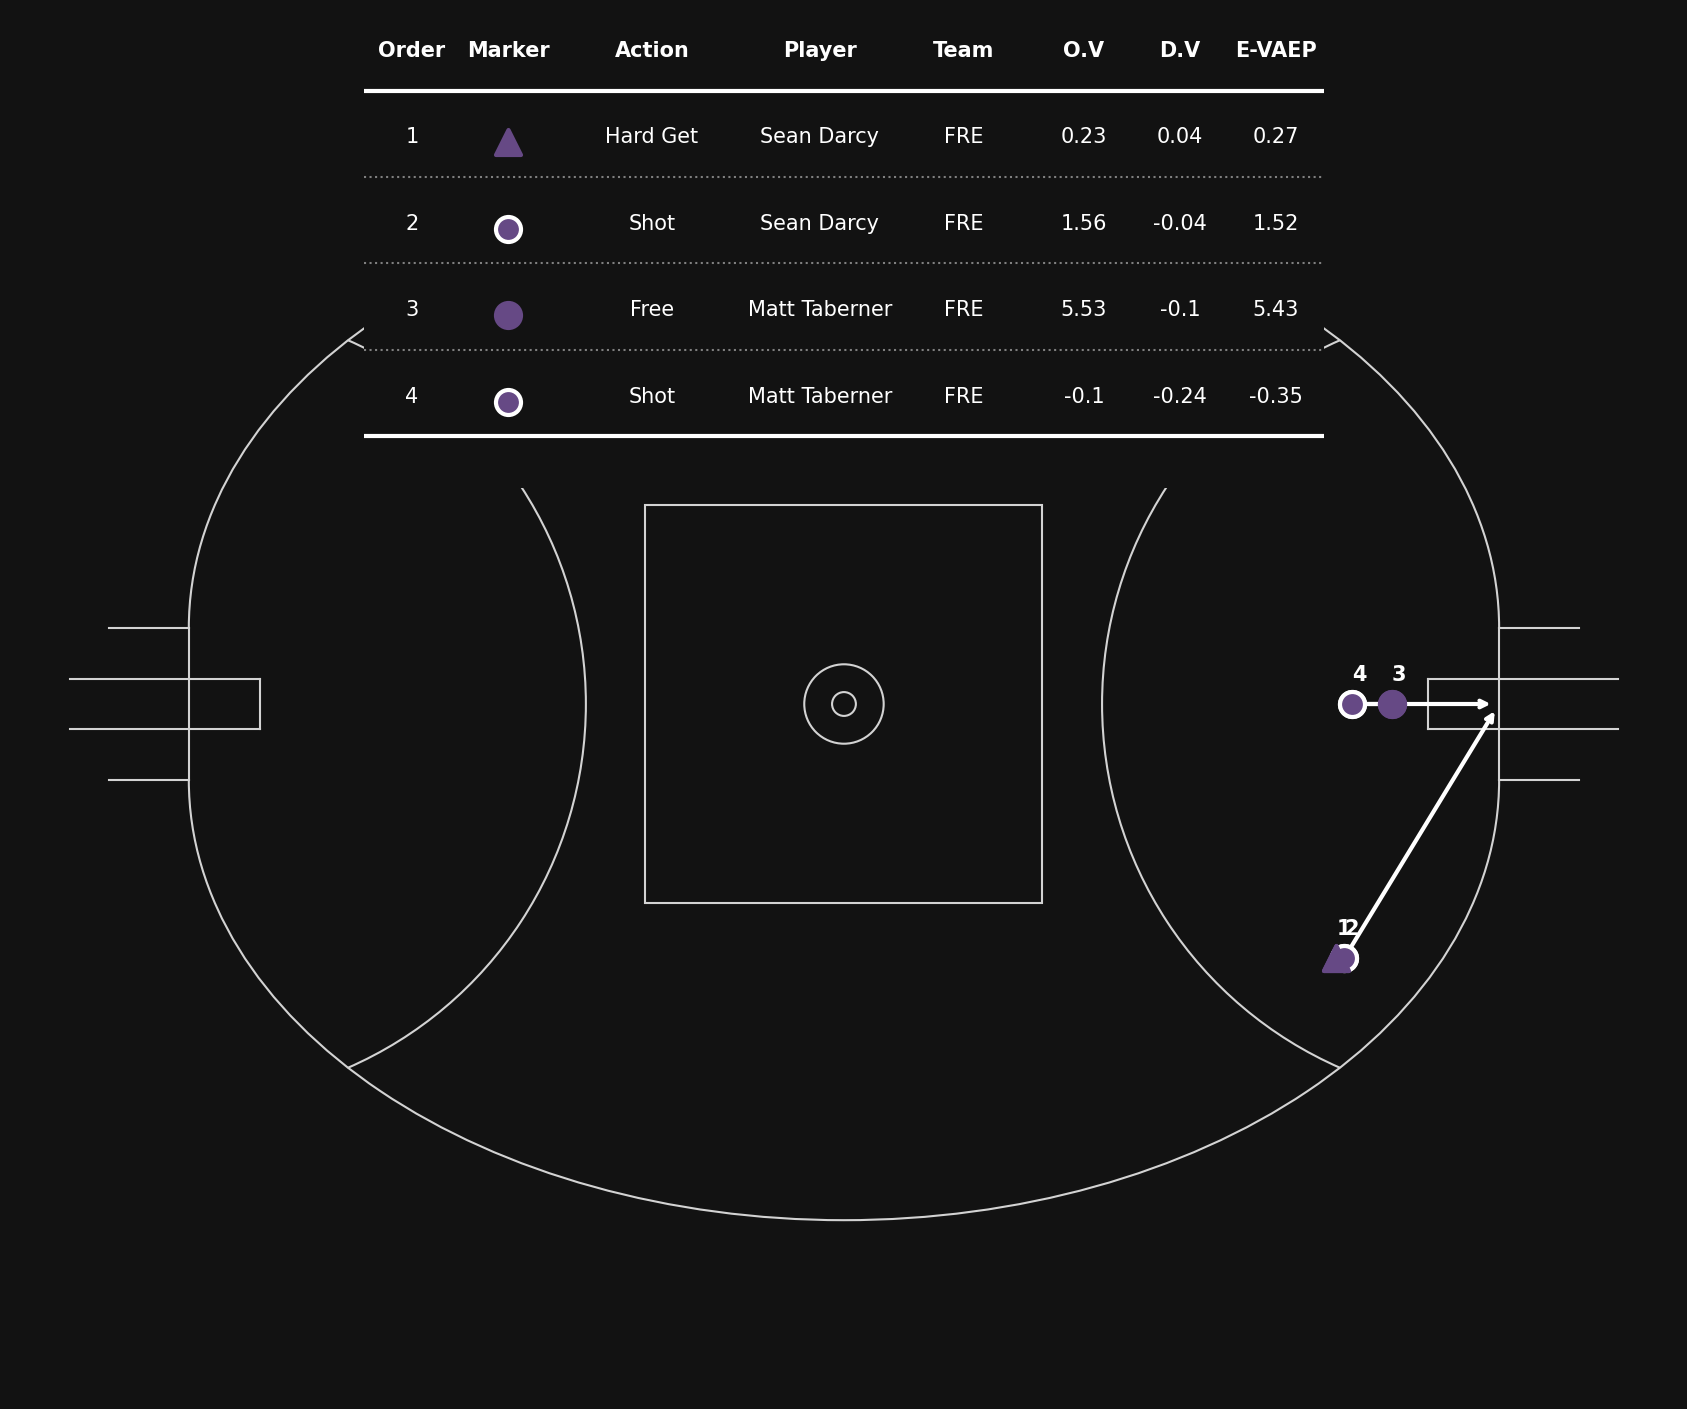

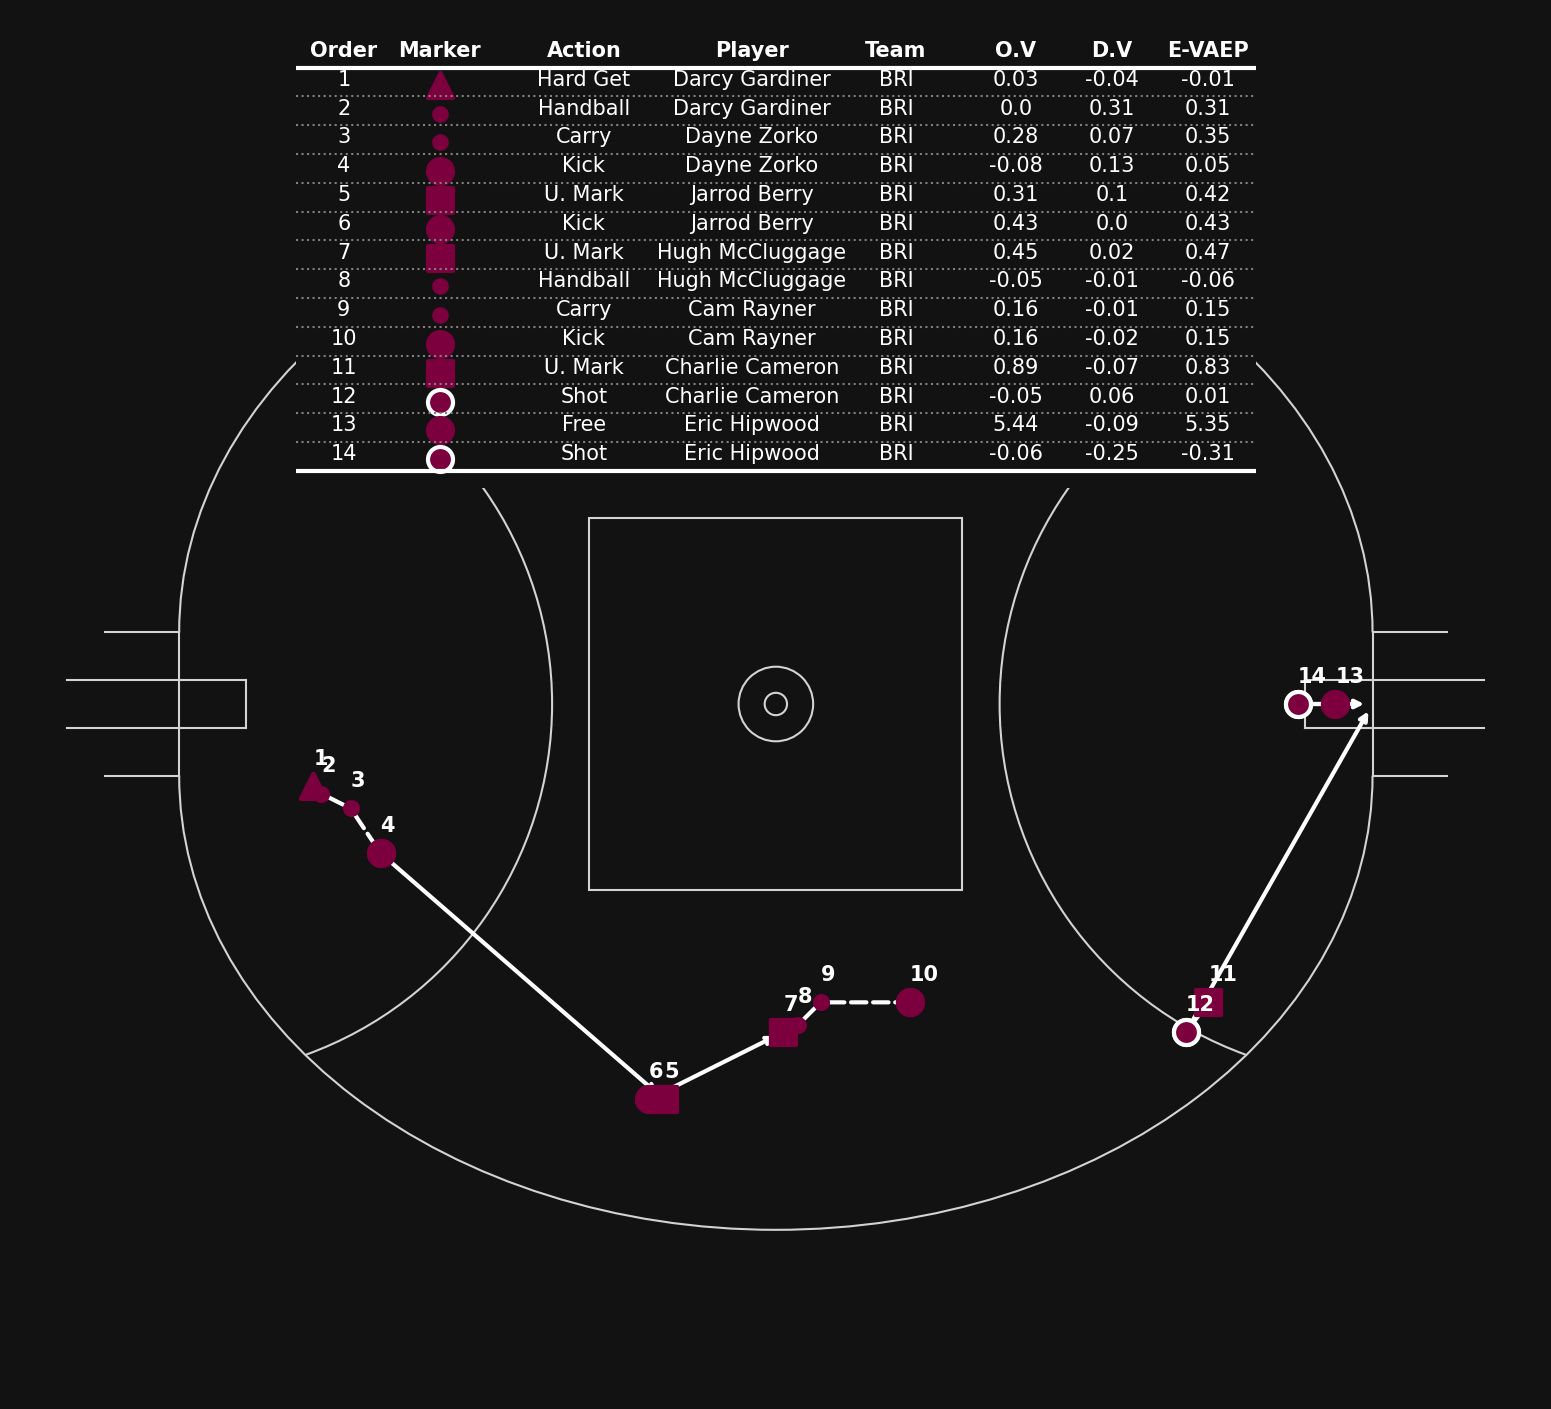

In [13]:
top_vaep_actions = chain_data.sort_values('exp_vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

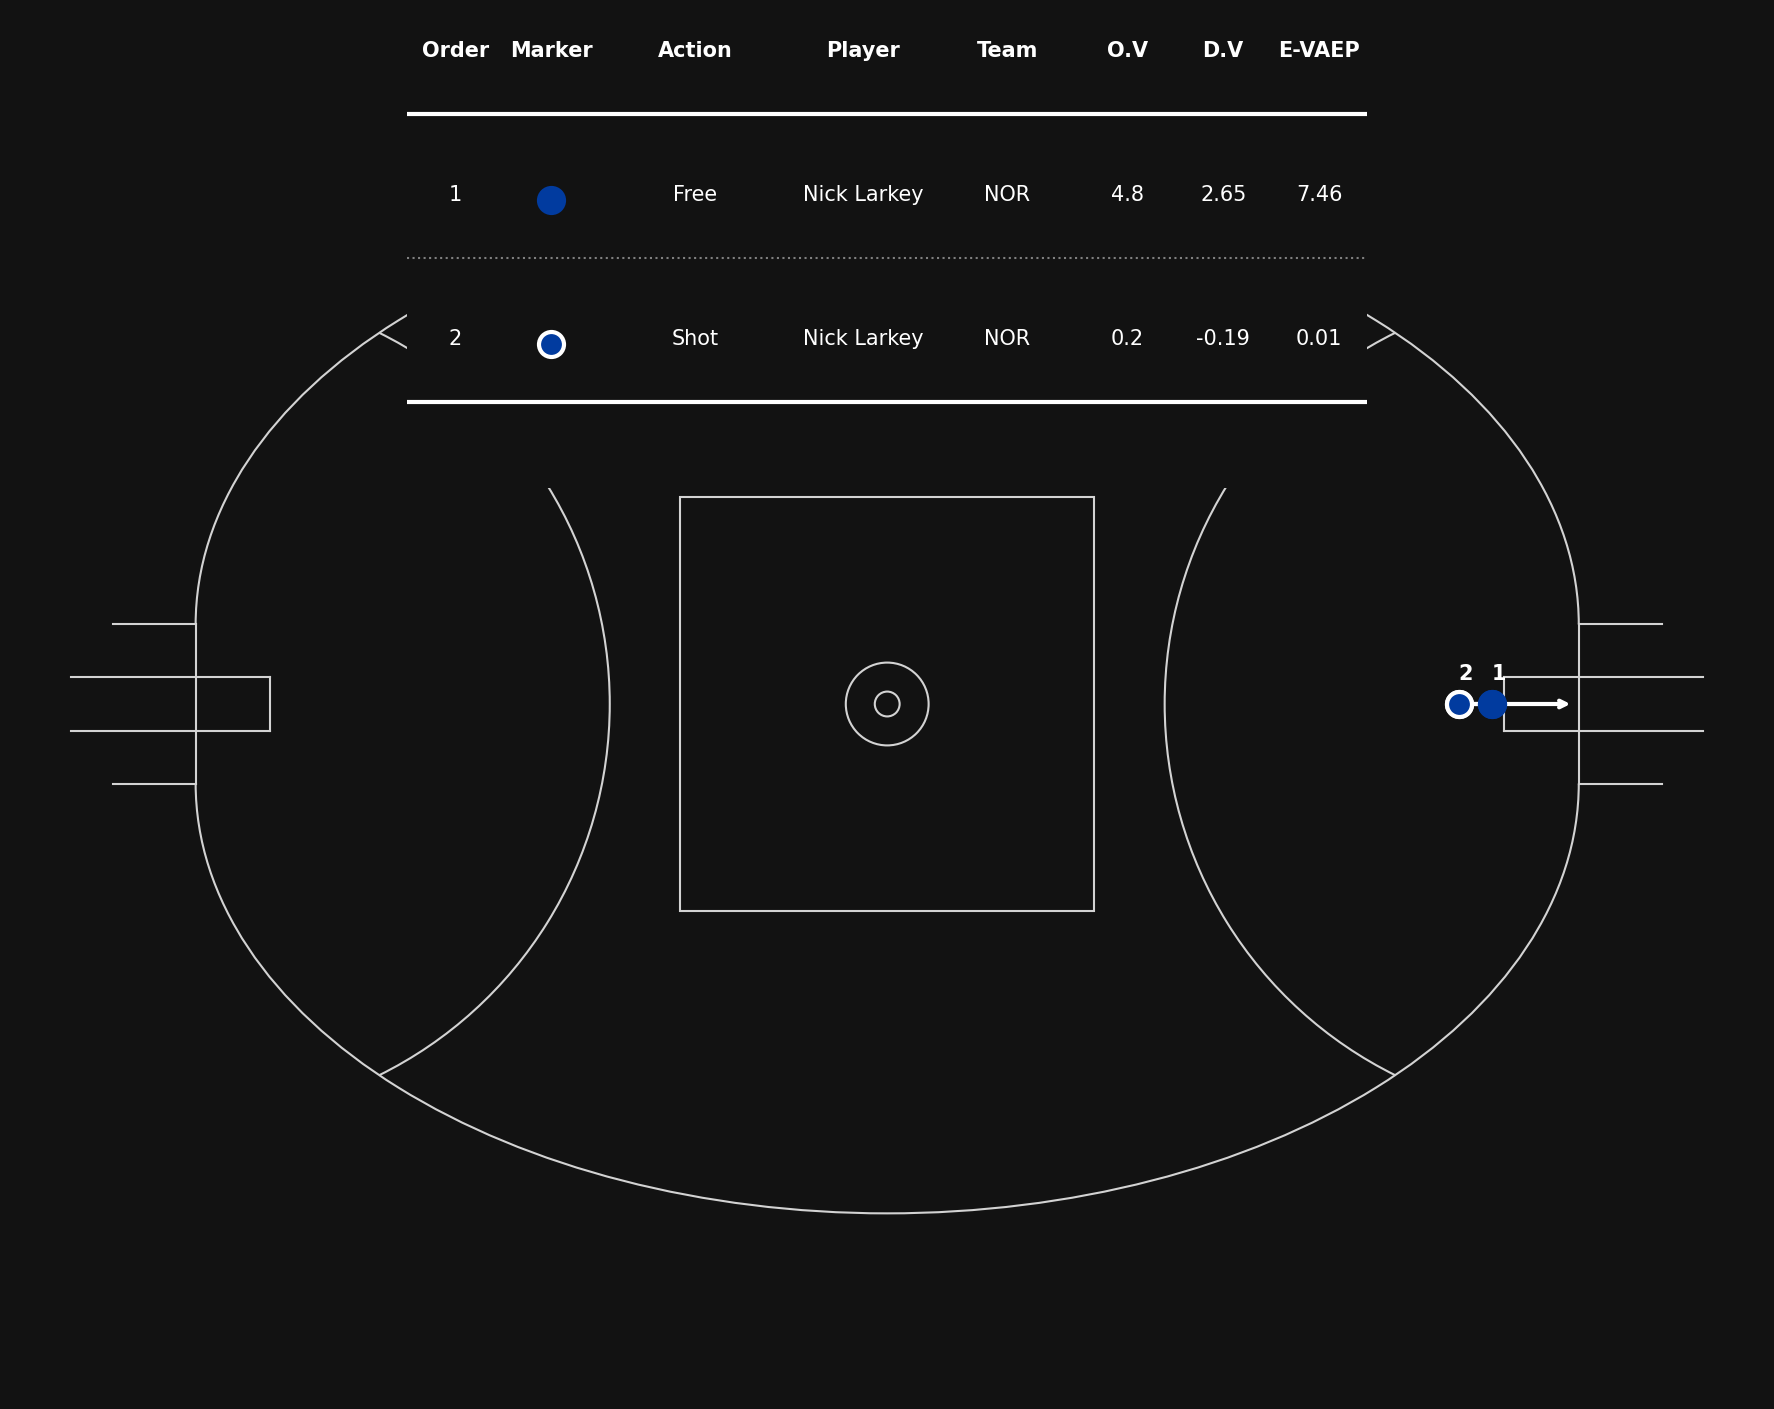

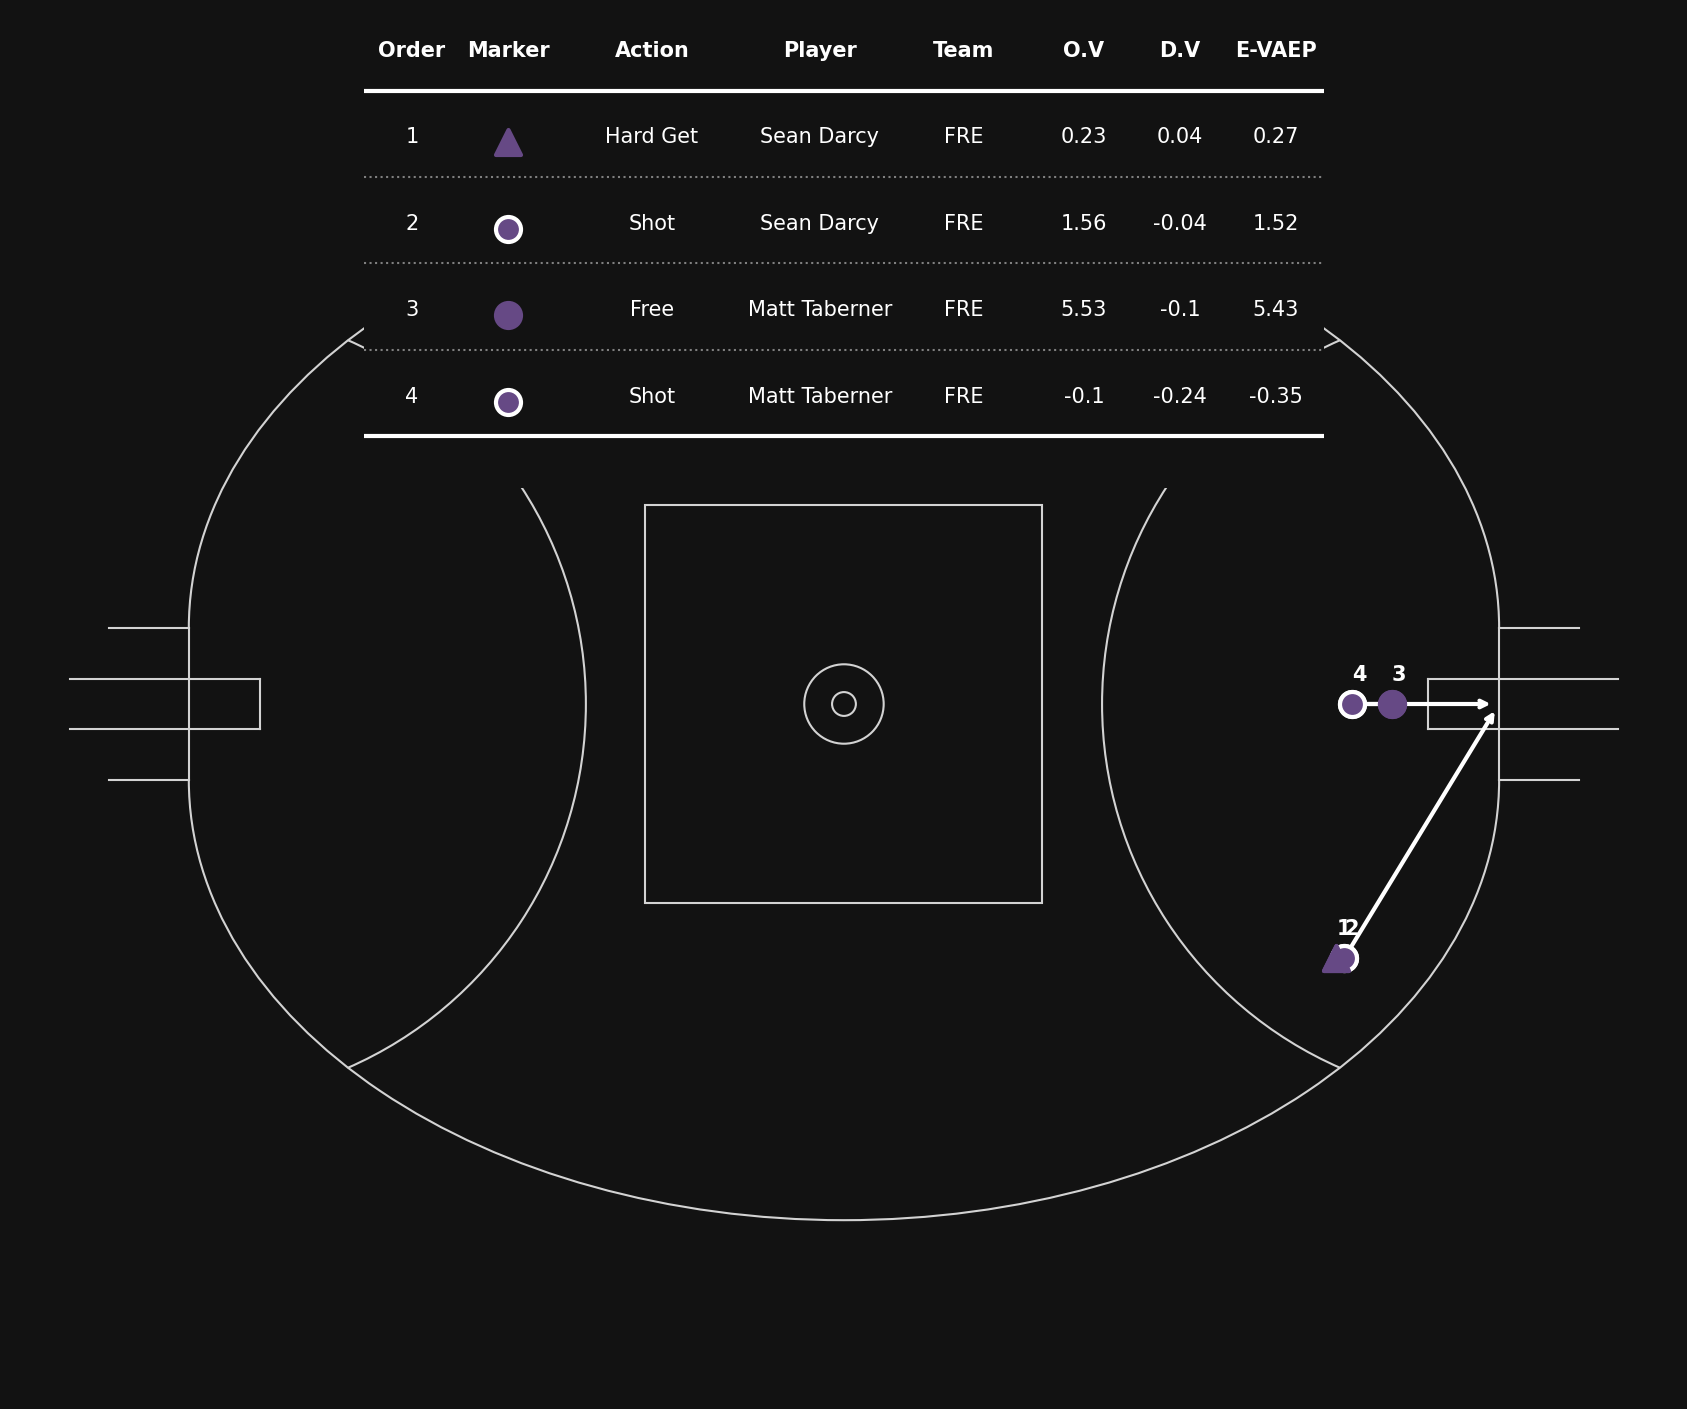

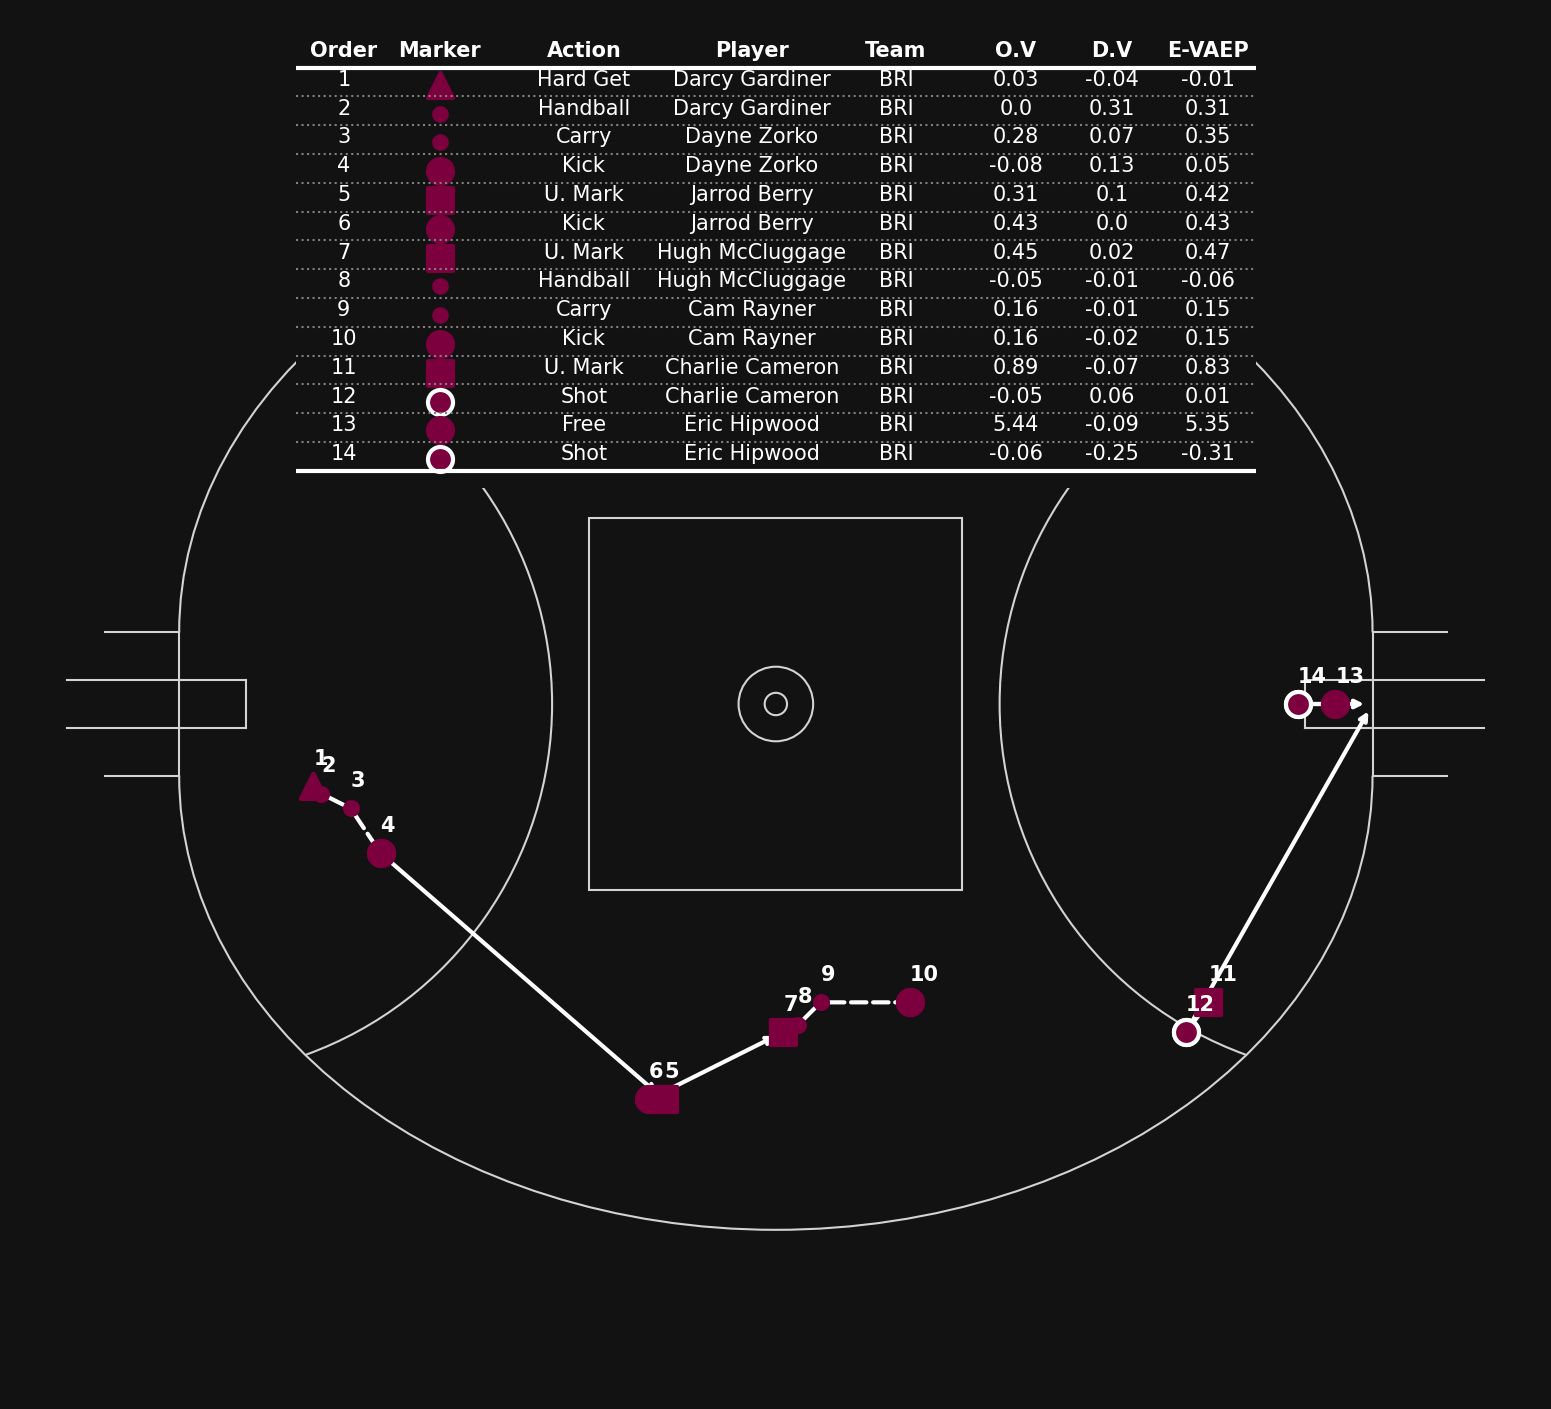

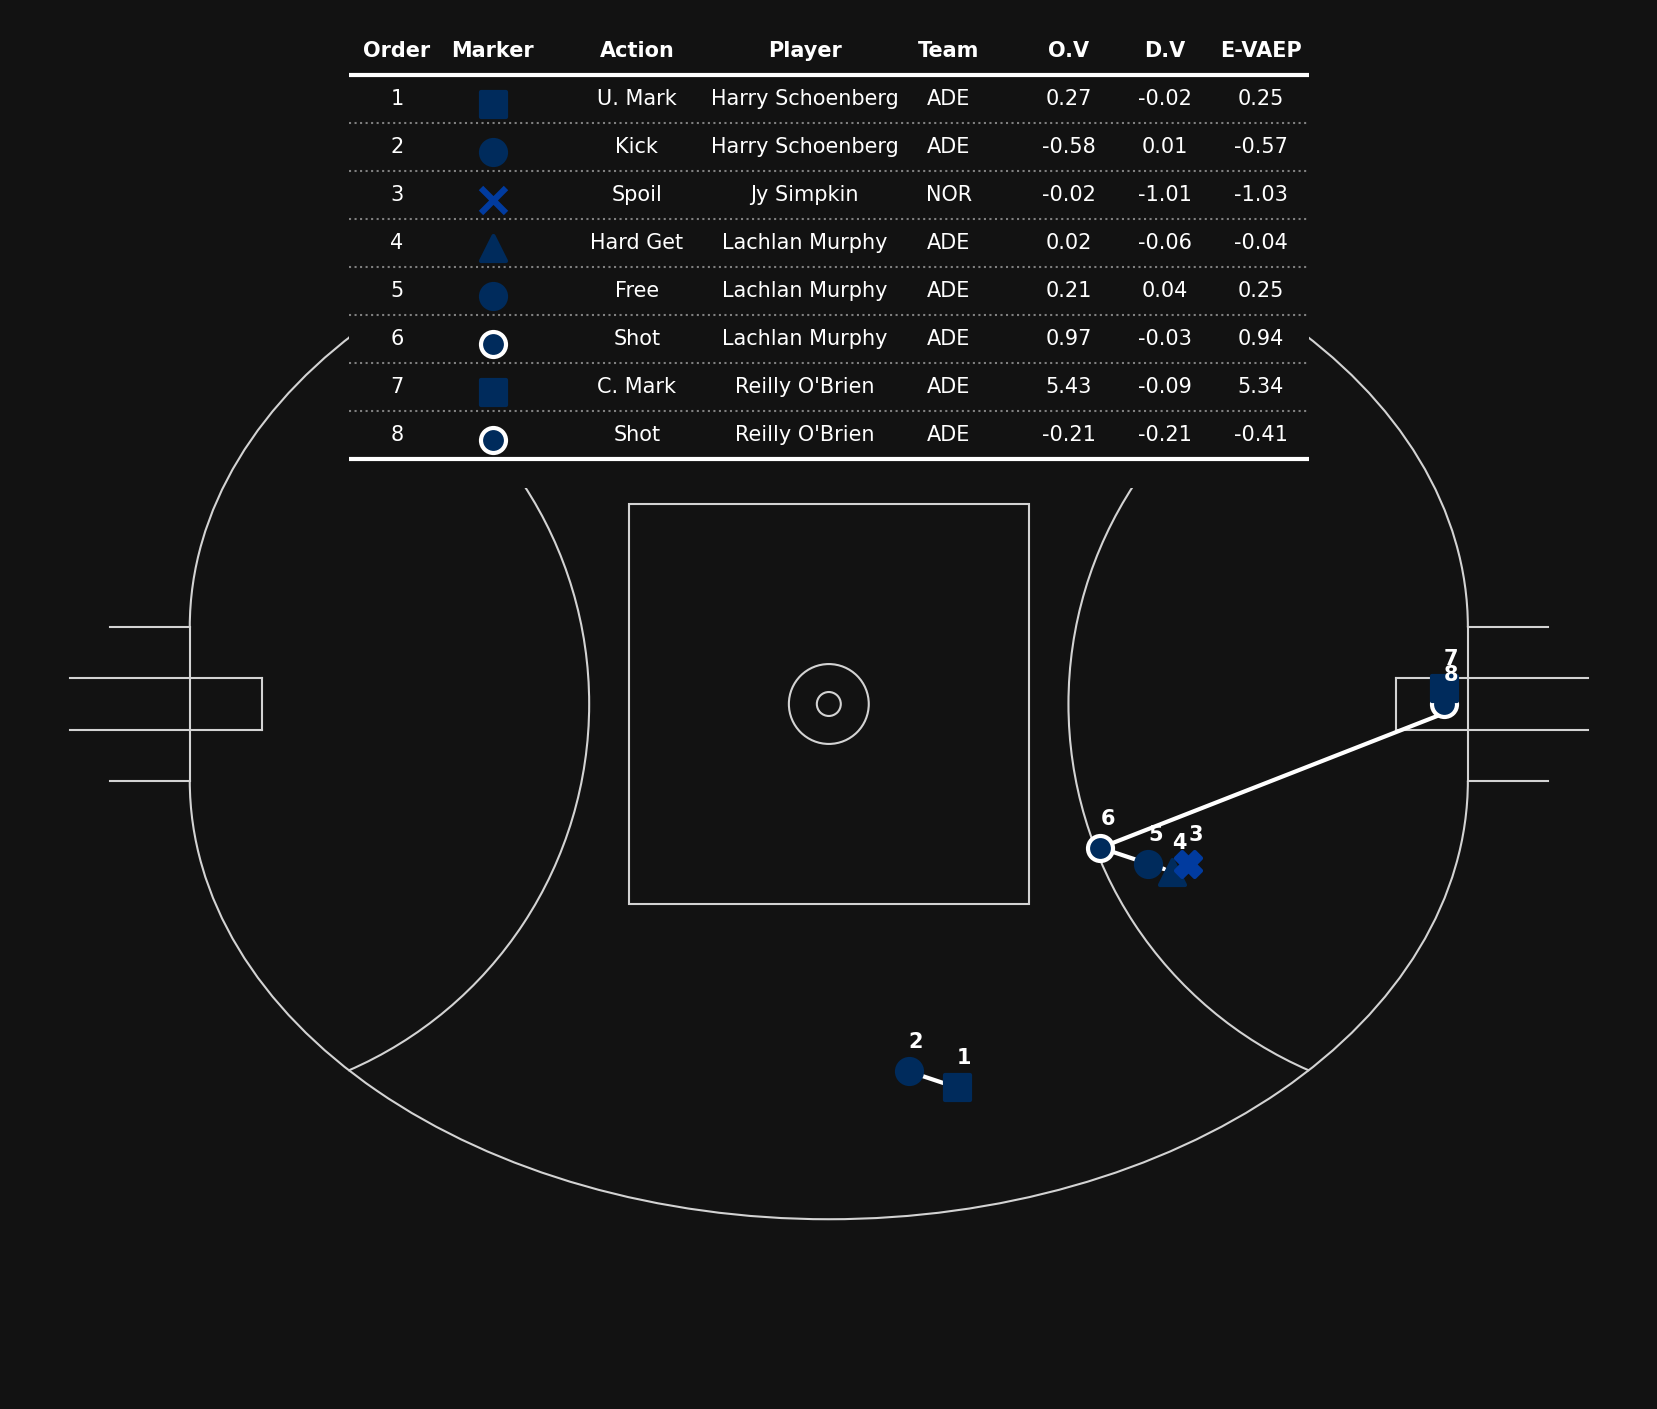

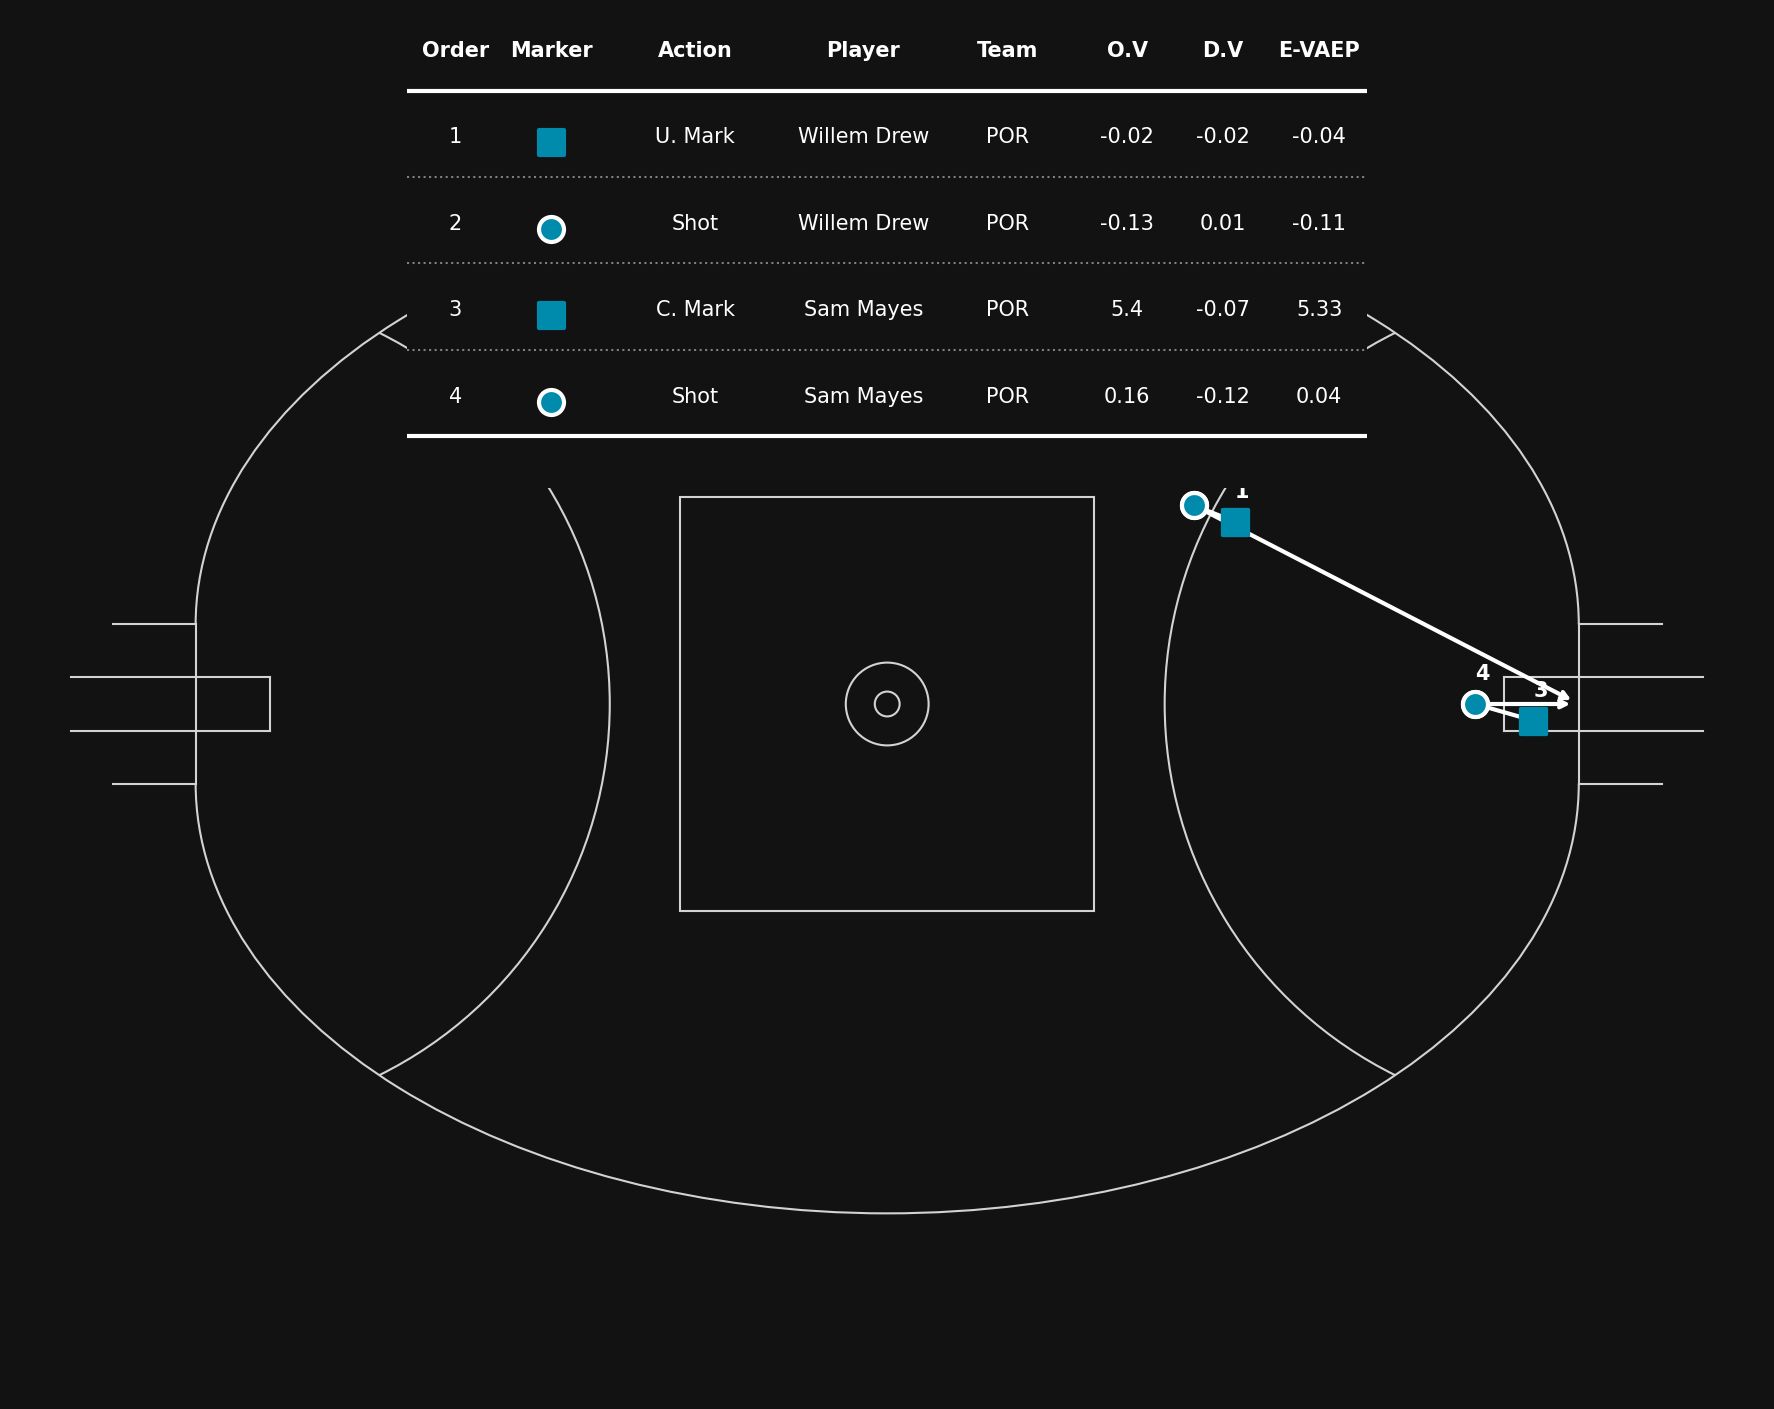

In [15]:
top_vaep_nonshot_actions = chain_data[~(chain_data['action_type'] == "Shot")].sort_values('exp_vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_nonshot_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_nonshot_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

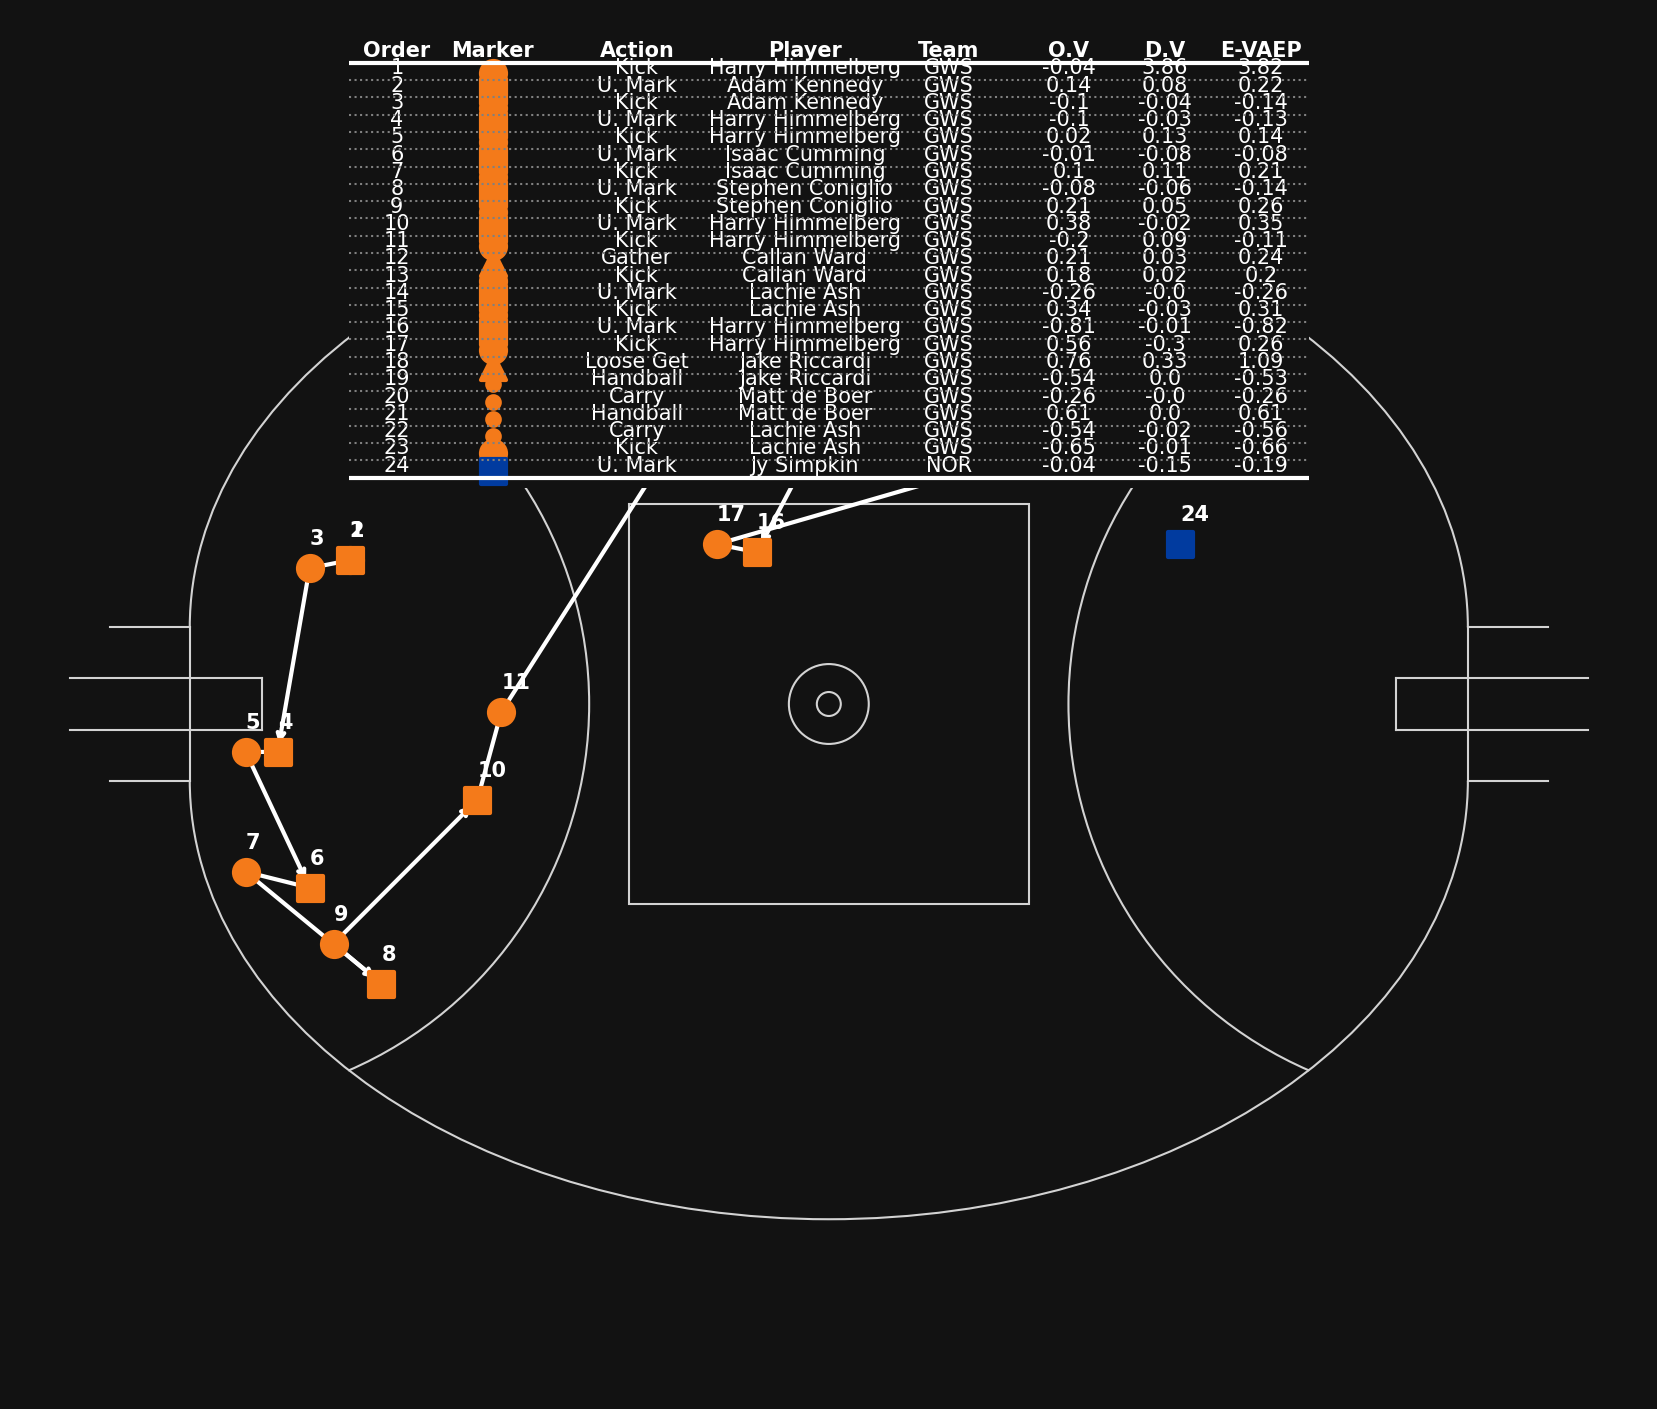

In [10]:
top_vaep_kick_actions = chain_data[(chain_data['action_type'] == "Kick")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_kick_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_kick_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

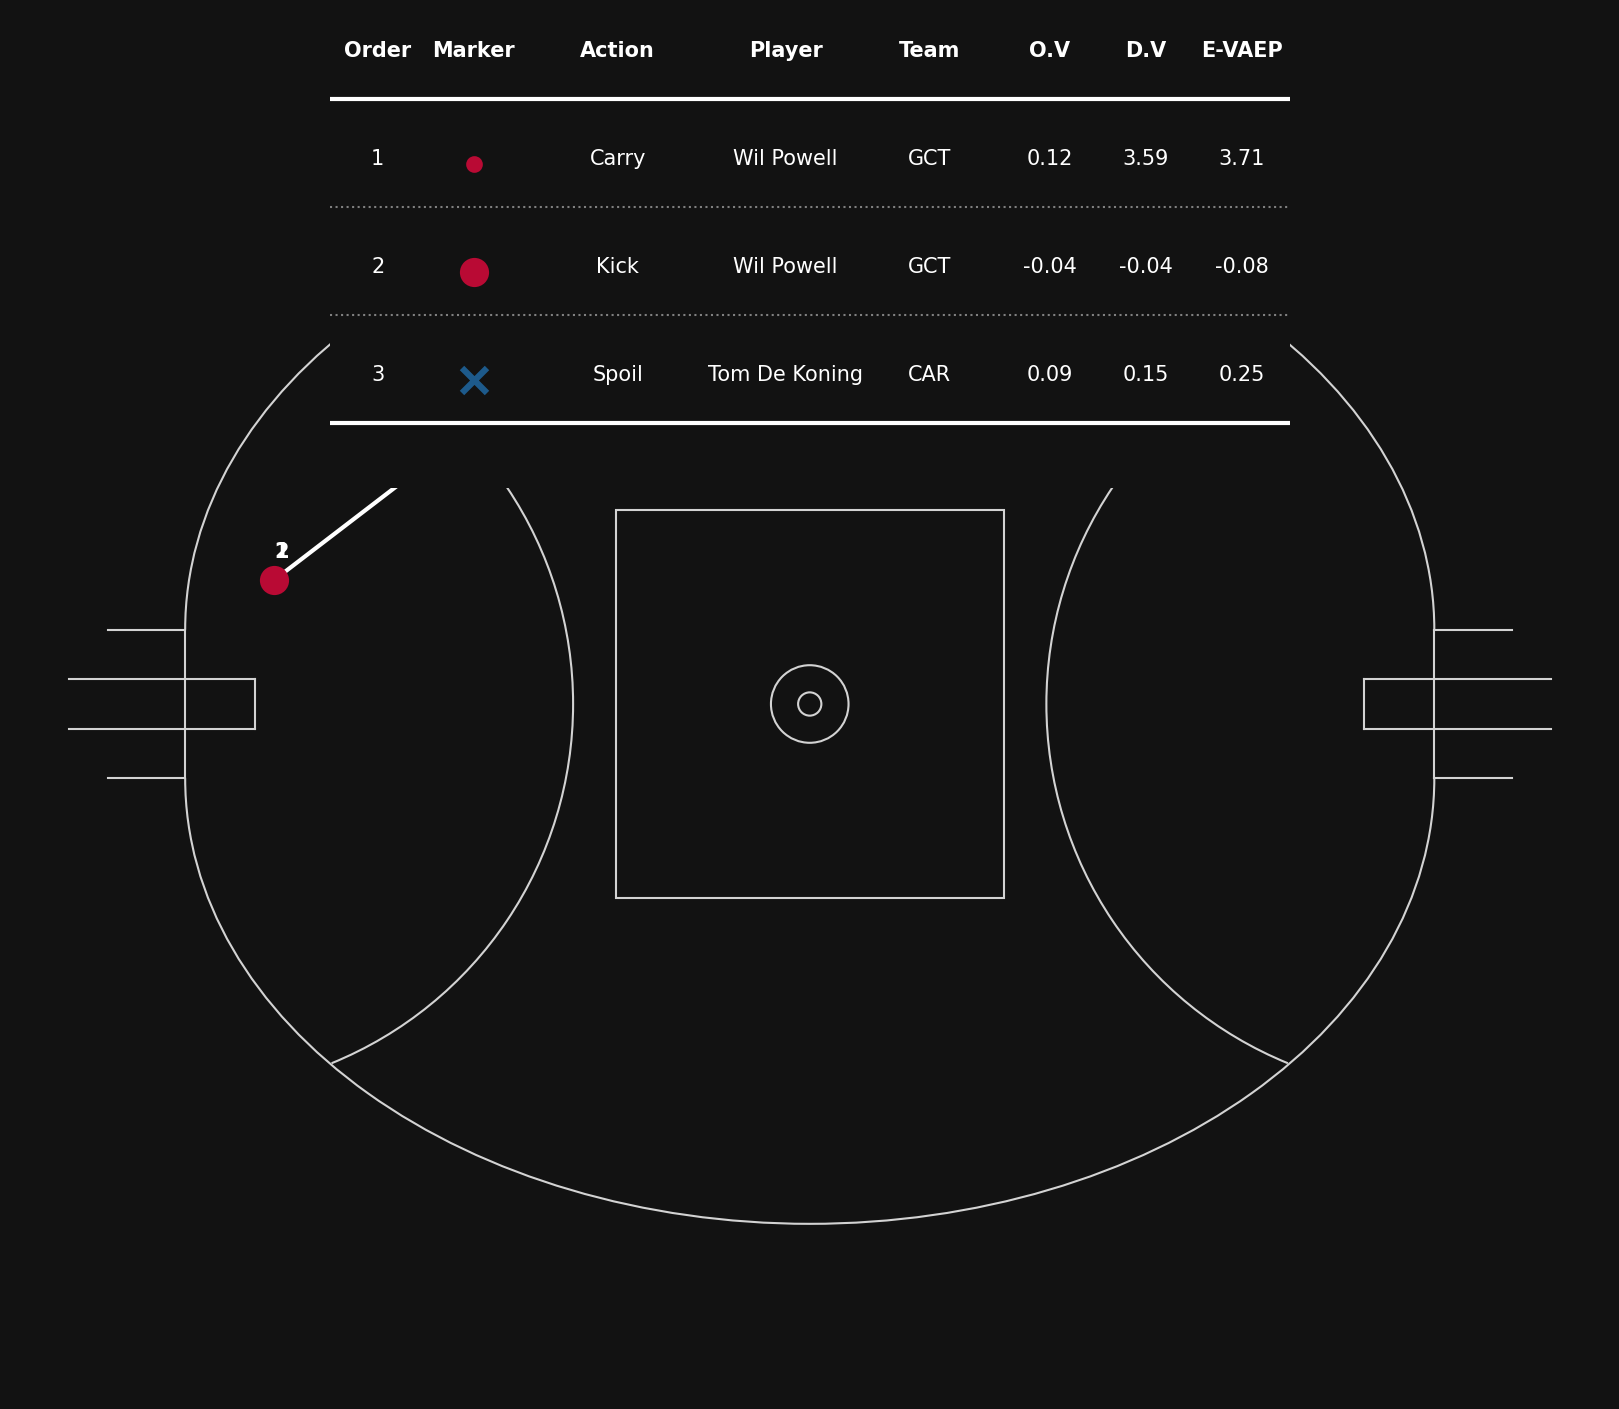

In [11]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Carry")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_carry_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_carry_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

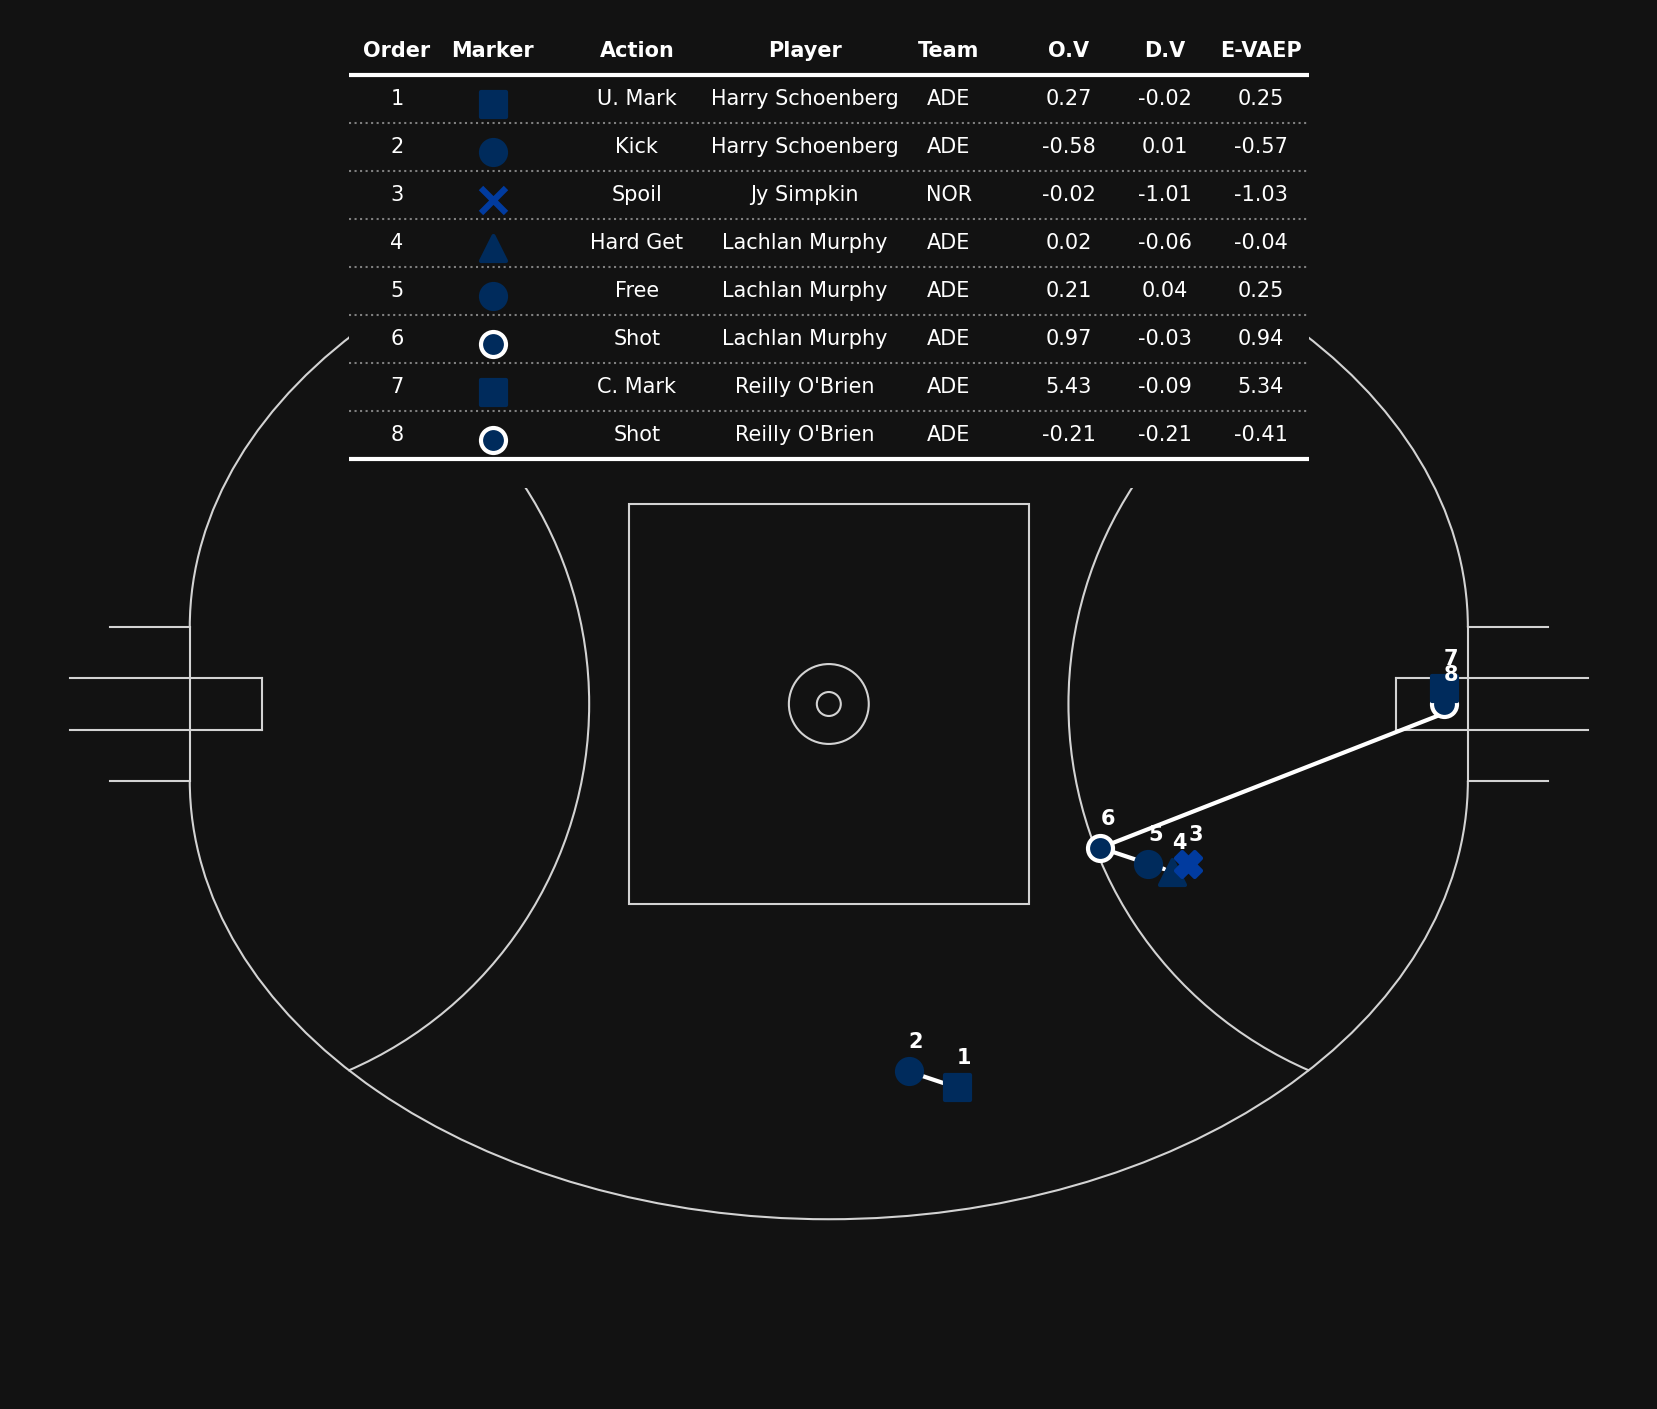

In [16]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Contested Mark")].sort_values('exp_vaep_value', ascending = False).head(1)
match_id = top_vaep_carry_actions['Match_ID'].iloc[0]
chain_number = top_vaep_carry_actions['Chain_Number'].iloc[0]
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)

pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

# plt.savefig(
# 	"../figures/20230814_vaep_chain.png",
# 	dpi = 300,
# 	facecolor = "#121212",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = False
# )